In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../")

import numpy as np
from src.utils.visualize import plotMatrix

import matplotlib.pyplot as plt
# %matplotlib widget
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import mutual_information, Statevector, partial_trace, concurrence, entanglement_of_formation

Using a wrapper lambda to fix parameter values in the basis gate for all search time. (Alternative is to fix only at beginning by overriding the beginning parameter guess - say if want to start near some known value but on new attempt let other variable that were previously fixed have some wiggle room)

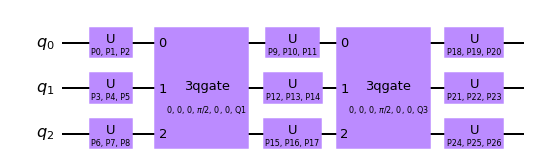

In [2]:
from src.basisv2 import CircuitTemplateV2
from src.utils.custom_gates import CirculatorSNAILGate
bind_lambda = lambda g_ab, t: CirculatorSNAILGate(0, 0, 0, np.pi/2, 0, 0, t)
basis = CircuitTemplateV2(n_qubits=3, base_gates = [bind_lambda], edge_params=[[(0,1,2)]])
basis.build(2)
basis.spanning_range = range(2,3)
basis.circuit.draw(output='mpl')

In [3]:
basis.add_bound("Q1", max=1, min=0)
basis.add_bound("Q3", max=1, min=0)

This template is same as from continuous_basis now, we have 2 iswap gates that are free to adjust their times. However, we have a 3rd qubit ancilla. That probably is not very helpful - we should remove it and just rewrite the gate class to be more adaptive. I think this test is at least a good way to quantify how much harder the increased hilbert space is for training - keeping the 3rd qubit just as ancilla.

In [15]:
from src.cost_function import BasicCostInverse, BasicCost
objective1 = BasicCost()
objective2 = BasicCostInverse()
from src.optimizer import TemplateOptimizer
optimizer = TemplateOptimizer(basis=basis, objective=objective1, use_callback=False, override_fail=True)

In [39]:
from src.sampler import HaarSample
sampler = HaarSample(seed=0,n_samples=1)
s = [s for s in sampler][0]
s = np.kron(s, np.eye(2))
ret = optimizer.approximate_target_U(s)

INFO:root:Begin search: (-1, -1, -1, -1)
INFO:root:Starting opt on template size 2
INFO:root:Break on cycle 2
INFO:root:Loss=2.9446445282133027e-12
INFO:root:Success: (-1, -1, -1, -1)


In [5]:
basis.build(ret.cycles)
circuit =basis.assign_Xk(ret.Xk)
print("Decomposition Fidelity", objective1.unitary_fidelity(basis.eval(ret.Xk), s))
print("Circuit Fidelity", basis.circuit_fidelity(ret.Xk))
print("Total Fidelity", 1-ret.loss_result)
circuit.draw(output='mpl')

NameError: name 'ret' is not defined

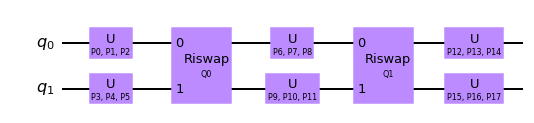

In [6]:
from src.basisv2 import CircuitTemplateV2
from src.utils.custom_gates import RiSwapGate
basis = CircuitTemplateV2(n_qubits=2, base_gates = [RiSwapGate], edge_params=[[(0,1)]])
basis.build(2)
basis.spanning_range = range(2,3)
basis.circuit.draw(output='mpl')

In [7]:
basis.add_bound("Q0", min=0, max=1)
basis.add_bound("Q1", min=0, max=1)

In [8]:
from src.sampler import HaarSample
sampler = HaarSample(seed=0,n_samples=1)
s = [s for s in sampler][0]

In [21]:
attempts = 3
previous_cost = 2
objective1 = BasicCost()
for i in range(attempts):
    if not previous_cost is None:
        basis.set_constraint(param_max_cost=.9*previous_cost)
        #pass
    #rebuild optimizer to refresh the updated f_basis obj
    optimizer3 = TemplateOptimizer(basis=basis, objective=objective1, use_callback=False, override_fail=True, training_restarts=5)

    _ret3 = optimizer3.approximate_target_U(s)
    previous_cost = basis.circuit_cost(_ret3.Xk)
    print(f"Iteration:{i}, Decomposition Success:{_ret3.loss_result}, Cost:{previous_cost},")

    #XXX bad
    if _ret3.loss_result >= 1e-7:
        break
    ret3 = _ret3

INFO:root:Begin search: (0.49741881, 0.30805173, 0.042267)
INFO:root:Starting opt on template size 2
INFO:root:Loss=7.436271604044364e-07
INFO:root:Fail: (0.49741881, 0.30805173, 0.042267), Alternative: (0.49753645, 0.30786842, 0.04283342)


Iteration:0, Decomposition Success:7.436271604044364e-07, Cost:1.382758247351815,


In [19]:
ret3=_ret3

Decomposition Fidelity 4.502466413036643e-07
Circuit Fidelity 0.5824296461551929
Total Fidelity 0.9999995497533587


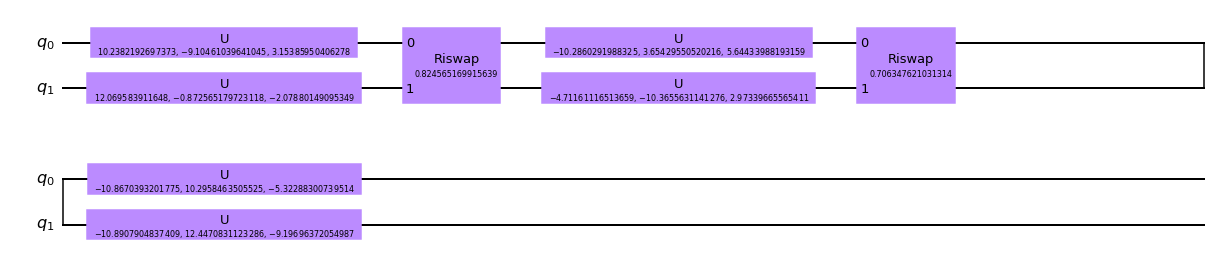

In [20]:
basis.build(ret3.cycles)
circuit =basis.assign_Xk(ret3.Xk)
print("Decomposition Fidelity", objective1.unitary_fidelity(basis.eval(ret3.Xk), s))
print("Circuit Fidelity", basis.circuit_fidelity(ret3.Xk))
print("Total Fidelity", 1-ret3.loss_result)
circuit.draw(output='mpl')